# Optimizer Convergence and Comparison

This notebook is dedicated to additional insights into the optimization process, be it convergence properties or comparisons of two different results.

**After this notebook you can...**

- Use visualization methods to compare optimizers in terms of performance
- check convergence of a multistart optimization
- get insights into the convergence history
- restart an optimization from a history file

## Imports and constants

In [25]:
import pypesto.optimize as optimize
import pypesto.visualize as visualize
import pypesto
import logging
import tempfile
import numpy as np
import scipy as sp
import copy
from IPython.display import Markdown, display

np.random.seed(3142)

## Creating optimization results

For the sake of this notebook, we create two optimization results done with different optimizers.

In [2]:
%%capture
# create problem
objective = pypesto.Objective(
    fun=sp.optimize.rosen,
    grad=sp.optimize.rosen_der,
    hess=sp.optimize.rosen_hess,
)
dim_full = 15
lb = -5 * np.ones((dim_full, 1))
ub = 5 * np.ones((dim_full, 1))

problem = pypesto.Problem(
    objective=objective, lb=lb, ub=ub
)

In [3]:
# optimizer
scipy_optimizer = optimize.ScipyOptimizer()

In [4]:
# create temporary storagefile...
f_scipy = tempfile.NamedTemporaryFile(suffix=".hdf5", delete=False)
fn_scipy = f_scipy.name

# ... and corresponding history option
history_options_scipy = pypesto.HistoryOptions(
    trace_record=True, storage_file=fn_scipy
)

**Note to the above:**

In practice you should not use a temporary file, as it is removed after the run, while still creating overhead. There are two options you might choose from instead:

- If you do not plan to save the optimization result, you can use a `MemoryHistory` by removing the `storage_file`-argument. This creates no overhead but is more demanding on the memory.
- If you want to save your results (**recommended**) for any form of reusability, you can remove `f_$optimizer` and replace the `fn_$optimizer`assignment with `fn_$optimizer = "filename_of_choice.hdf5"`

In [5]:
n_starts = 10

# run optimization
result_scipy = optimize.minimize(
    problem=problem,
    optimizer=scipy_optimizer,
    n_starts=n_starts,
    history_options=history_options_scipy,
    filename=fn_scipy,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.32s/it]


In a first step we compare the optimizers in terms of final objective function and robustness through a waterfall plot.

## Optimizer convergence

First we want to check convergence of a single result. For this a summary and general visualizations such as waterfall-plots can be helpfull, but also specific optimizer_convergence visualization as well as history tracing.

In [6]:
display(Markdown(result_scipy.summary()))

## Optimization Result 

* number of starts: 10 
* best value: 1.1156490576891858e-10, id=8
* worst value: 3.9866238138797487, id=9
* number of non-finite values: 0

* execution time summary:
	* Mean execution time: 1.316s
	* Maximum execution time: 1.957s,	id=6
	* Minimum execution time: 0.819s,	id=1
* summary of optimizer messages:

  |   Count | Message                                         |
  |--------:|:------------------------------------------------|
  |      10 | CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH |

* best value found (approximately) 9 time(s)
* number of plateaus found: 1

A summary of the best run:

### Optimizer Result

* optimizer used: <ScipyOptimizer method=L-BFGS-B options={'disp': False, 'maxfun': 1000}>
* message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH 
* number of evaluations: 110
* time taken to optimize: 1.316s
* startpoint: [ 2.49775229 -4.93575586 -0.96507193 -4.90511172 -3.96909126  0.34152167
 -2.05712605  3.32840348 -3.07422127  1.11162062  1.98350063 -2.75493257
  2.90622105 -4.58360239 -4.29519499]
* endpoint: [0.99999964 0.99999968 0.99999991 1.00000019 1.00000033 1.00000029
 1.00000019 1.00000008 1.00000002 1.00000004 1.00000005 1.00000027
 1.00000073 1.00000157 1.00000315]
* final objective value: 1.1156490576891858e-10
* final gradient value: [-2.63412251e-04 -2.50472548e-04 -1.04938427e-05  1.26103711e-04
  2.46790826e-04  9.44020239e-05  6.62994158e-05 -8.48337856e-05
 -1.89848493e-04  2.35845564e-04 -2.81067317e-04  6.87665799e-05
  2.26058394e-05 -1.98511123e-05  1.58481106e-05]


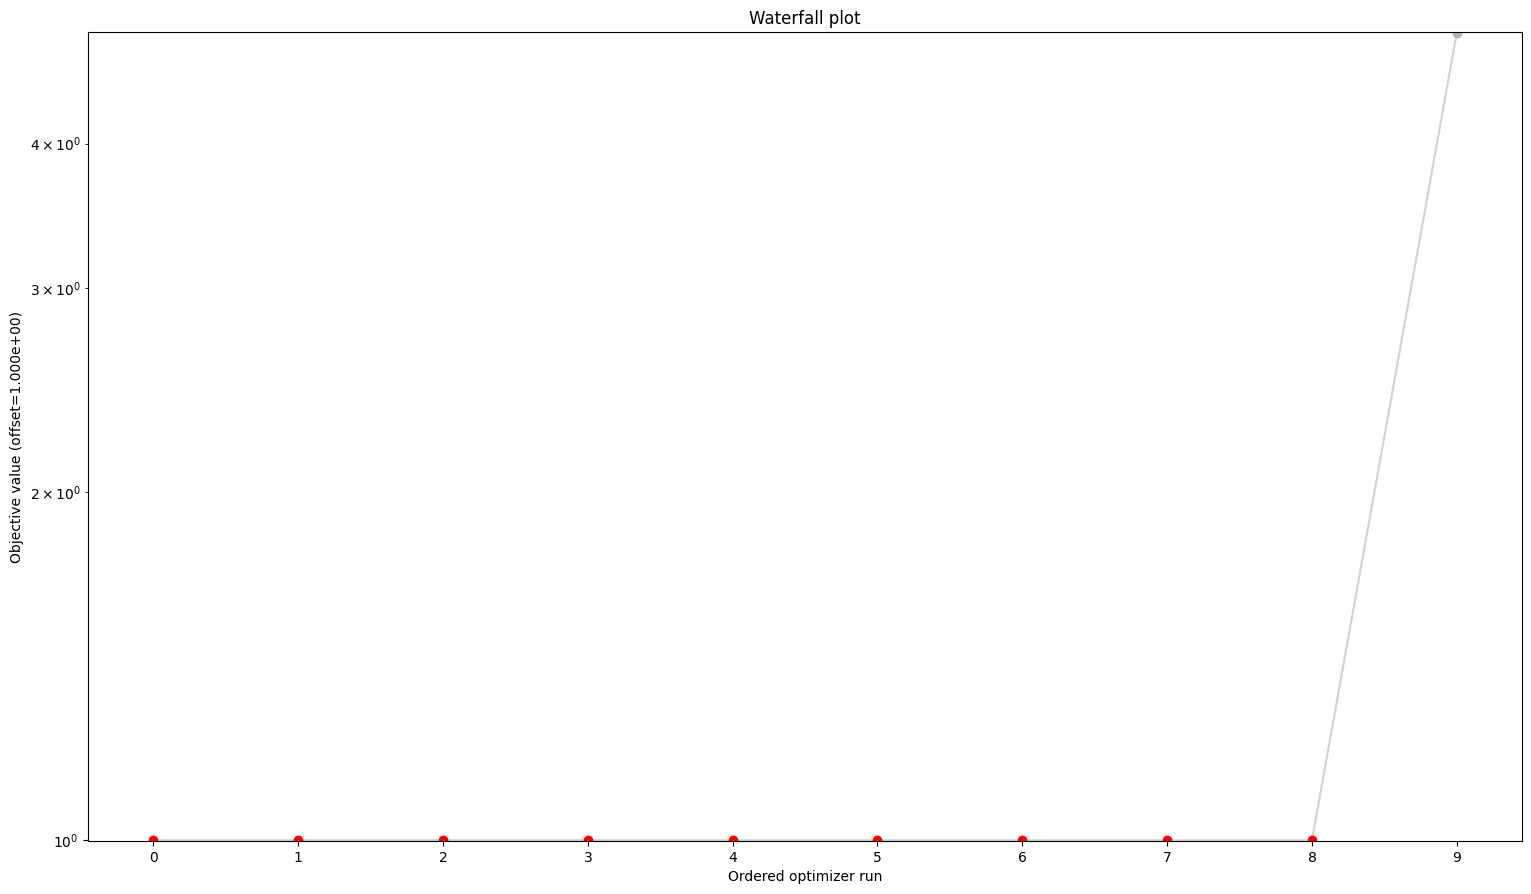

In [7]:
# waterfall plot
visualize.waterfall(result_scipy);

The waterfall plot is an overview of the final objective function values. They are ordered from best to worst. Similar colors indicate similar function values and potential local optima/mannifolds. In the best case scenario all values are assigned to a plateau indicating local optima and the best value is found more then once. Additionally we might want to check whether the gradients converged as well and whether we can find a pattern in specific reasons to stop:

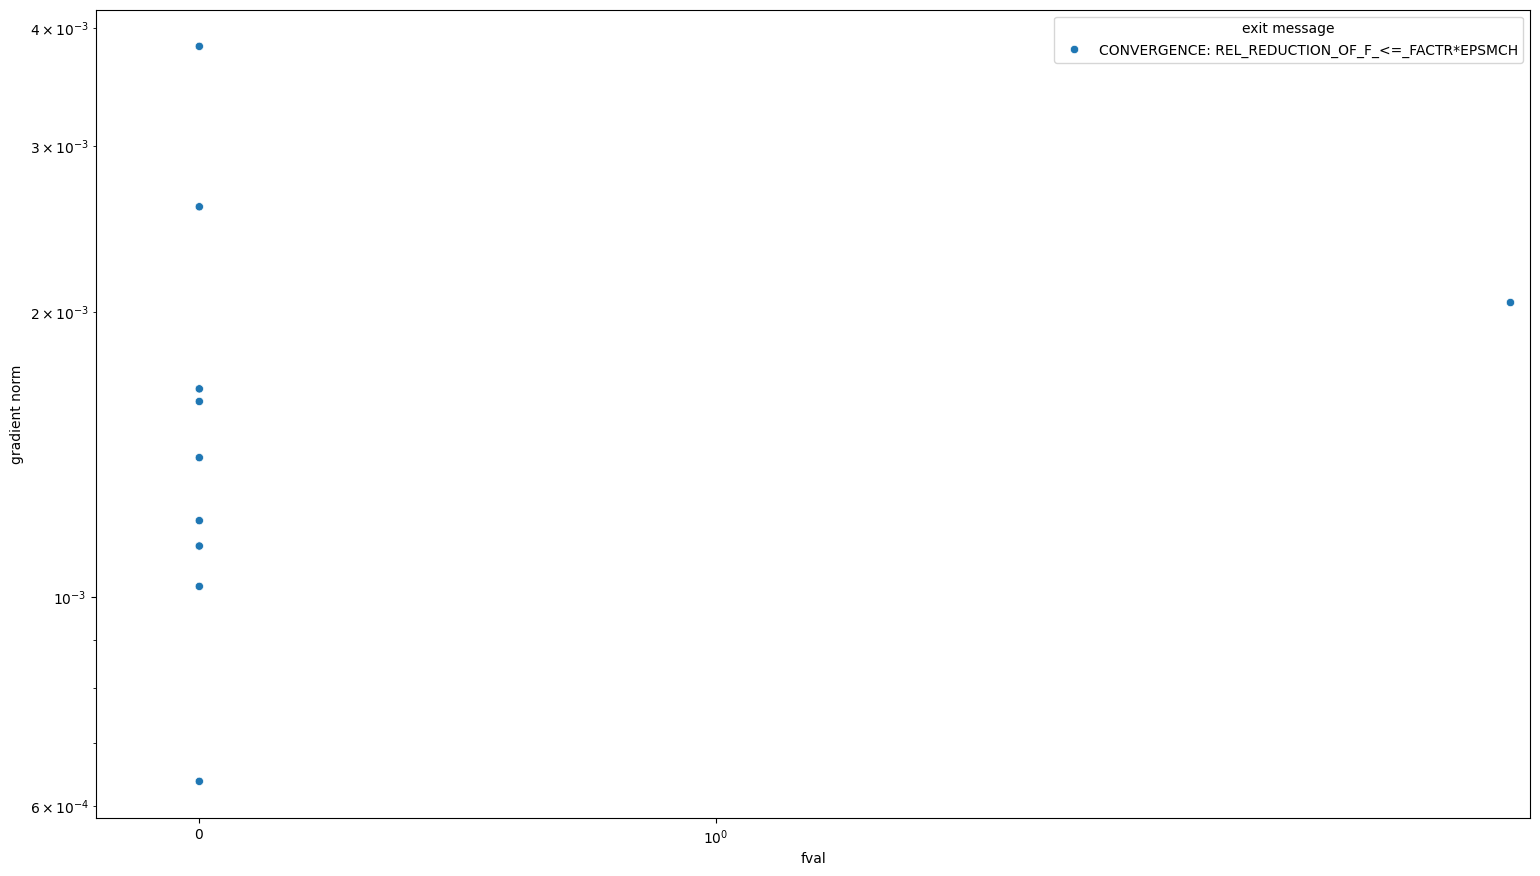

In [8]:
visualize.optimizer_convergence(result_scipy);

We usually want the gradients to be very low, in order to actually ensure we are in a local optimum. If the results do not seem entirely promising, we might want to switch optimizers altogether, as different optimizers sometimes perform better for other problems. Additionally one can try changing the optimizer.

In [9]:
# switch to fides optimizer
fides_optimizer = optimize.FidesOptimizer(
    verbose=logging.WARN
)
f_fides = tempfile.NamedTemporaryFile(suffix=".hdf5", delete=False)
fn_fides = f_fides.name
history_options_fides = pypesto.HistoryOptions(
    trace_record=True, storage_file=fn_fides
)
result_fides = optimize.minimize(
    problem=problem,
    optimizer=fides_optimizer,
    n_starts=n_starts,
    history_options=history_options_fides,
    filename=fn_fides,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.73it/s]


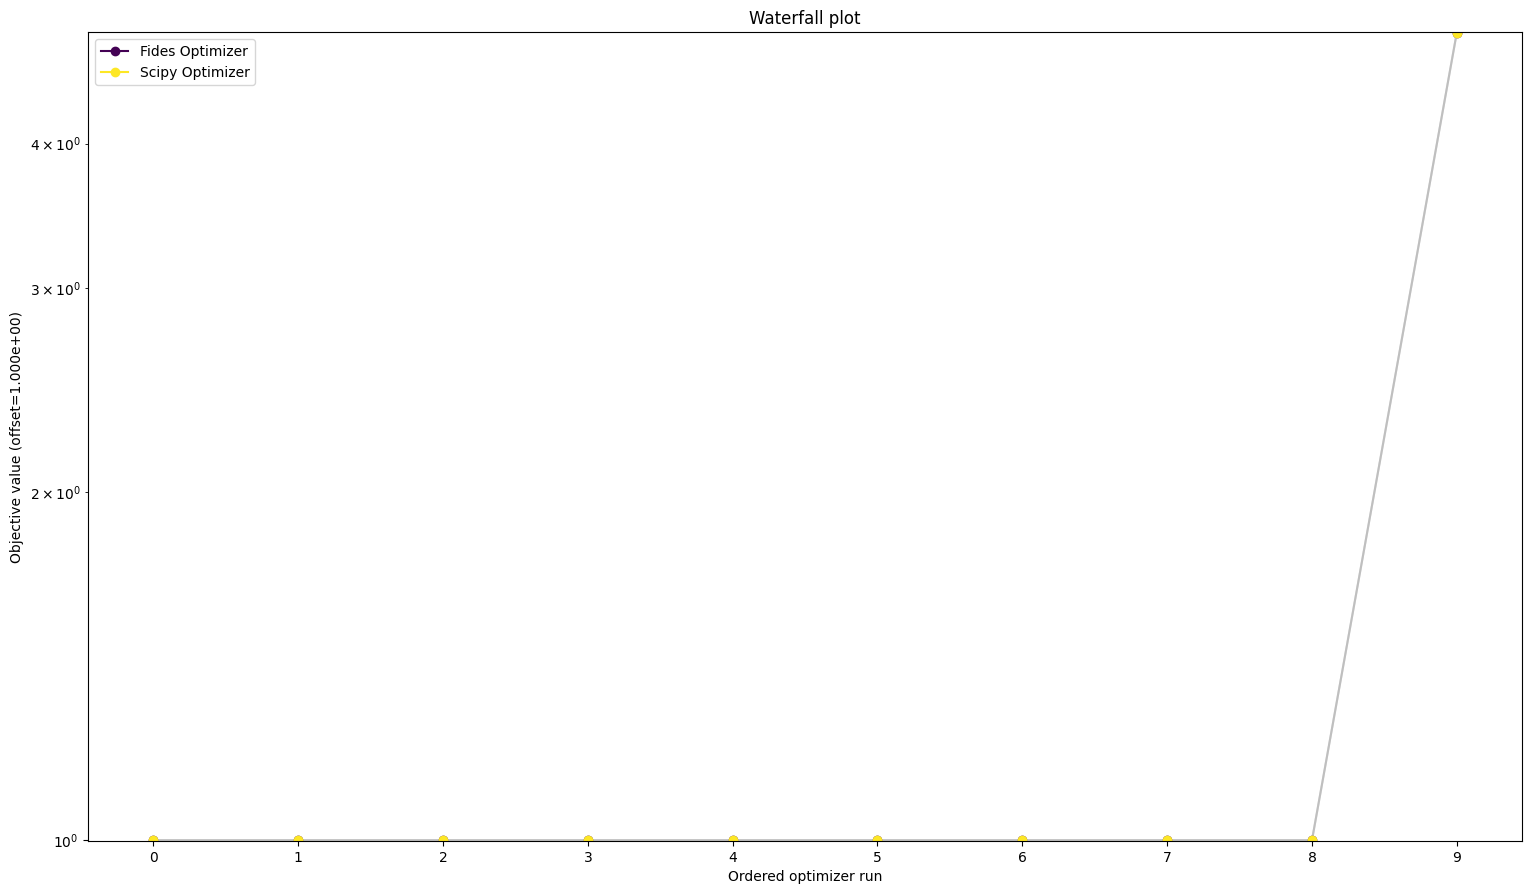

In [10]:
visualize.waterfall([result_fides, result_scipy], legends=["Fides Optimizer", "Scipy Optimizer"]);

We can also compare various metrics of the results, such as time and number of evaluations

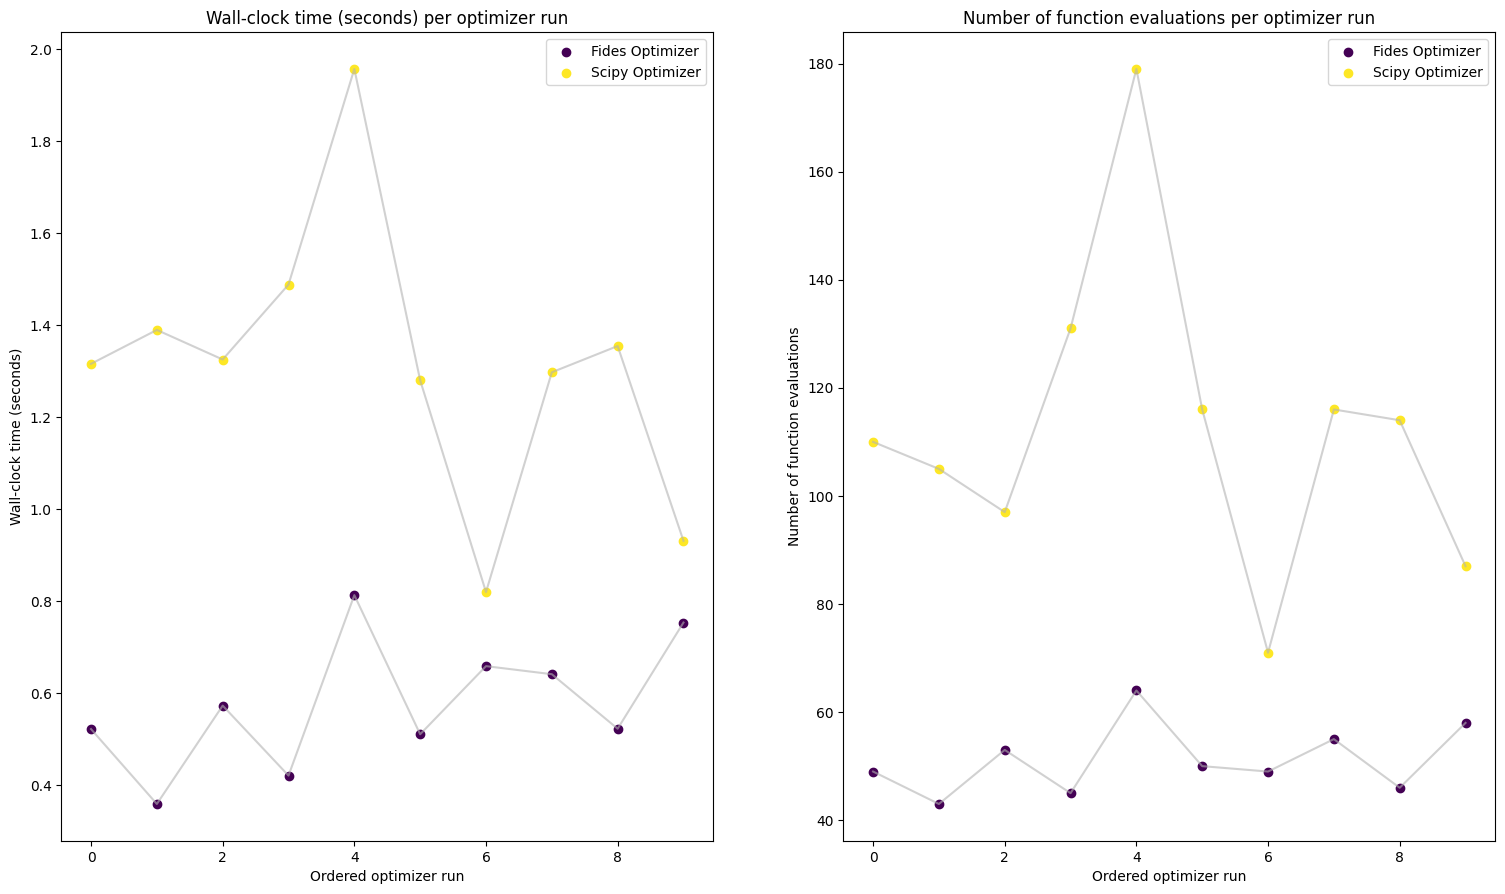

In [11]:
visualize.optimization_run_properties_per_multistart(
        [result_fides, result_scipy], properties_to_plot=['time', 'n_fval'],
        legends=["Fides Optimizer", "Scipy Optimizer"] 
);

We might want to check how close the estimated guesses are together, for this we can employ the parameter visualization.

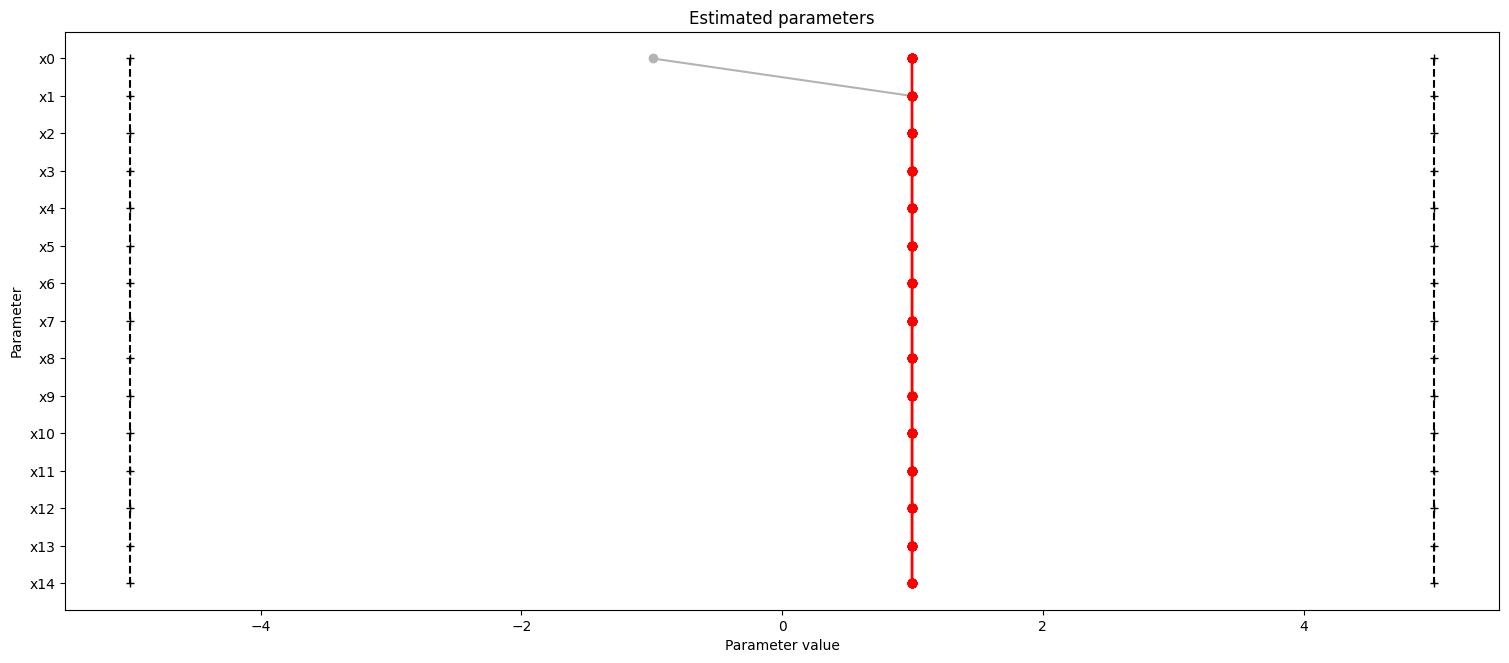

In [12]:
visualize.parameters(result_fides);

We can also check how the optimization trajectory looks like during the different runs, getting other reasons such as very flat landscapes, that can be additonal reasons for the optimization to stop. For this the we use the history:

Reference point is currently only implemented for trace_y == fval and will not be plotted for trace_y == gradnorm.


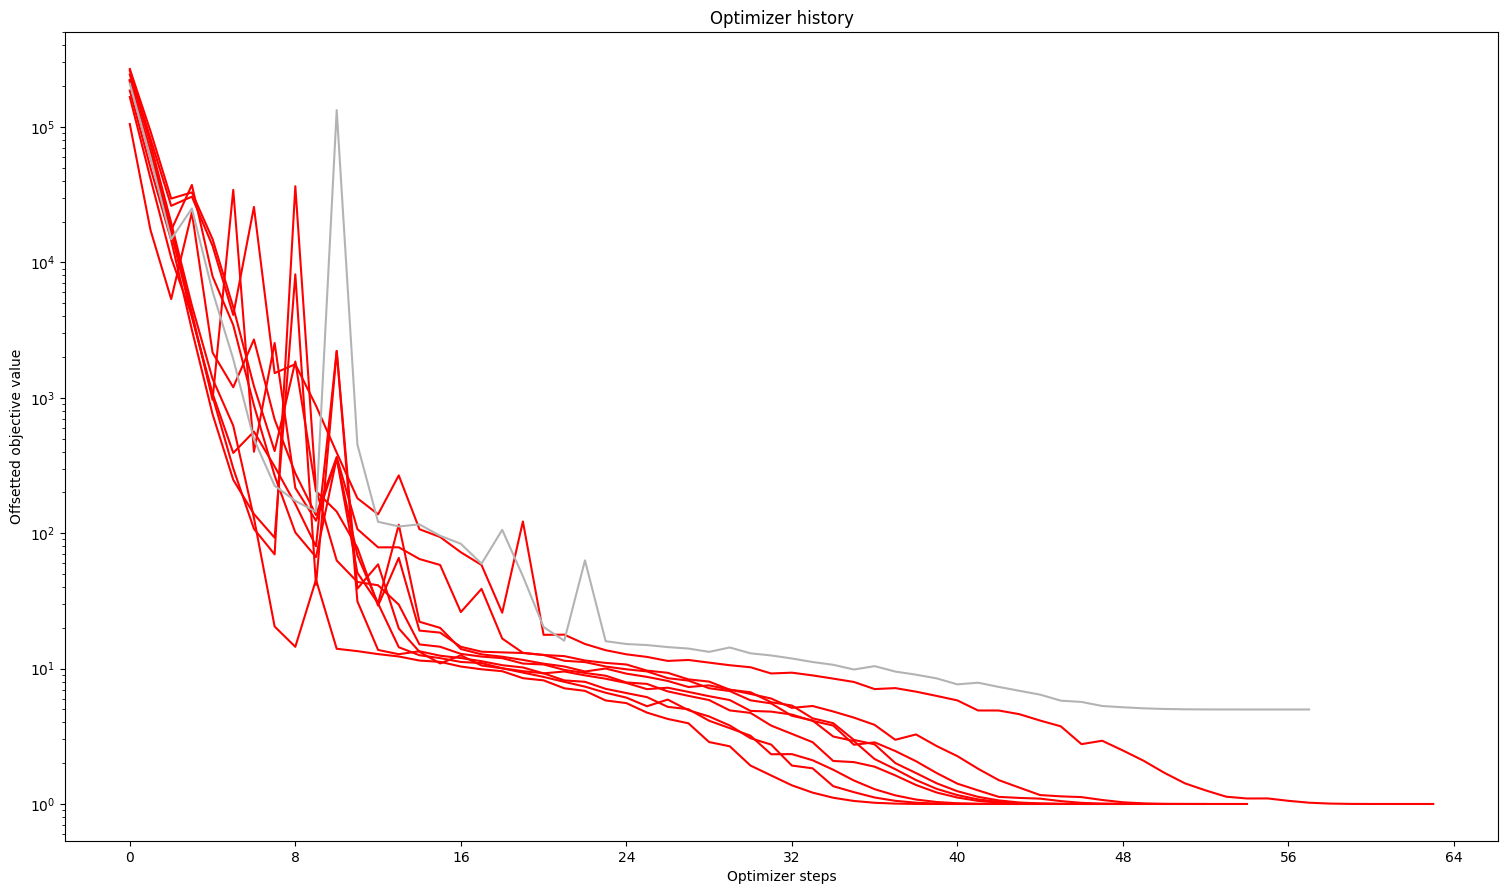

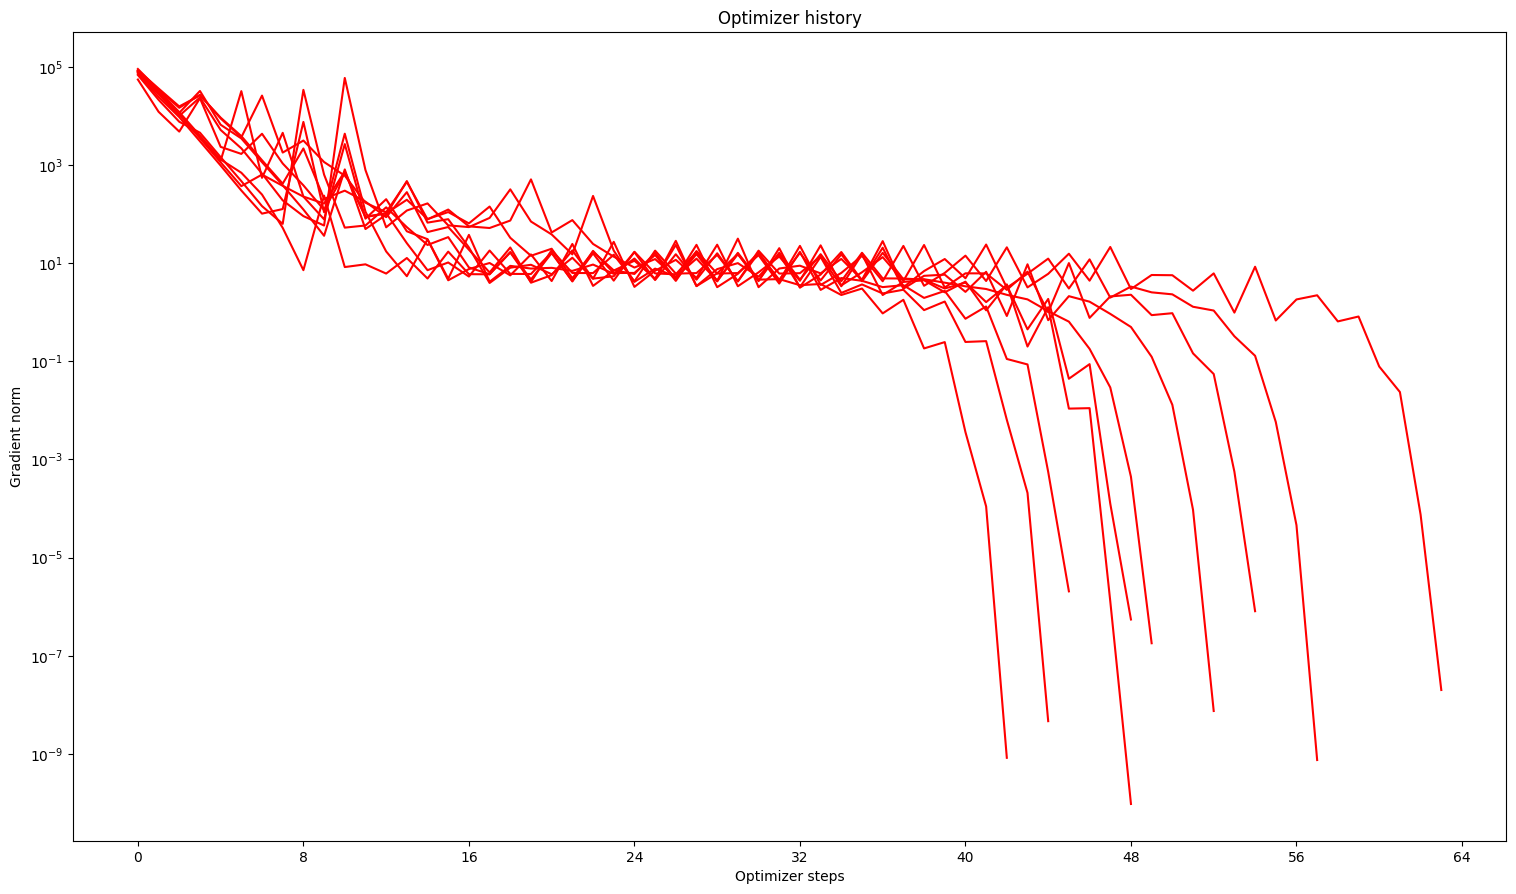

In [13]:
visualize.optimizer_history(result_fides, trace_y="fval")
visualize.optimizer_history(result_fides, trace_y="gradnorm");

As we can see the function values are not monotonic. This is due to the optimization tracing line search evaluations as well. This allows us to investigate potential problems. Recurring patterns in the gradient norm together with miniscule to no changes in the function values indicate the optimizer to not be able to really find another next point or taking spiraling steps. In both cases the actual optimum is very hard to pinpoint.
Lowering tolerances, increasing startpoints (up to a certain point), switching optimizers are all valid strategies in trying to overcome such issues. However, there is no recipe for all models and thus it is always important to investigate the optimization in terms of convergence, termination reasons and function evaluations, to get ideas on what to do next.

## Reloading from History

Especially when running large models on clusters, the optimization sometimes my stop due to unfortunate reasons (e.g. timeouts). In these cases, the history serves yet another purpose: retrieving finished and unfinished optimizations. Sometimes out of 100 starts, 80 might have already been terminated, in this case, investigating those 80 might already yield good results. In other cases, we might want to continue optimization from where we left of.

In [18]:
# load result from history
result_from_history = optimize.optimization_result_from_history(problem=problem, filename=fn_fides)
result_from_history.problem = problem

We can check that the visualization still is the same as in the original result.

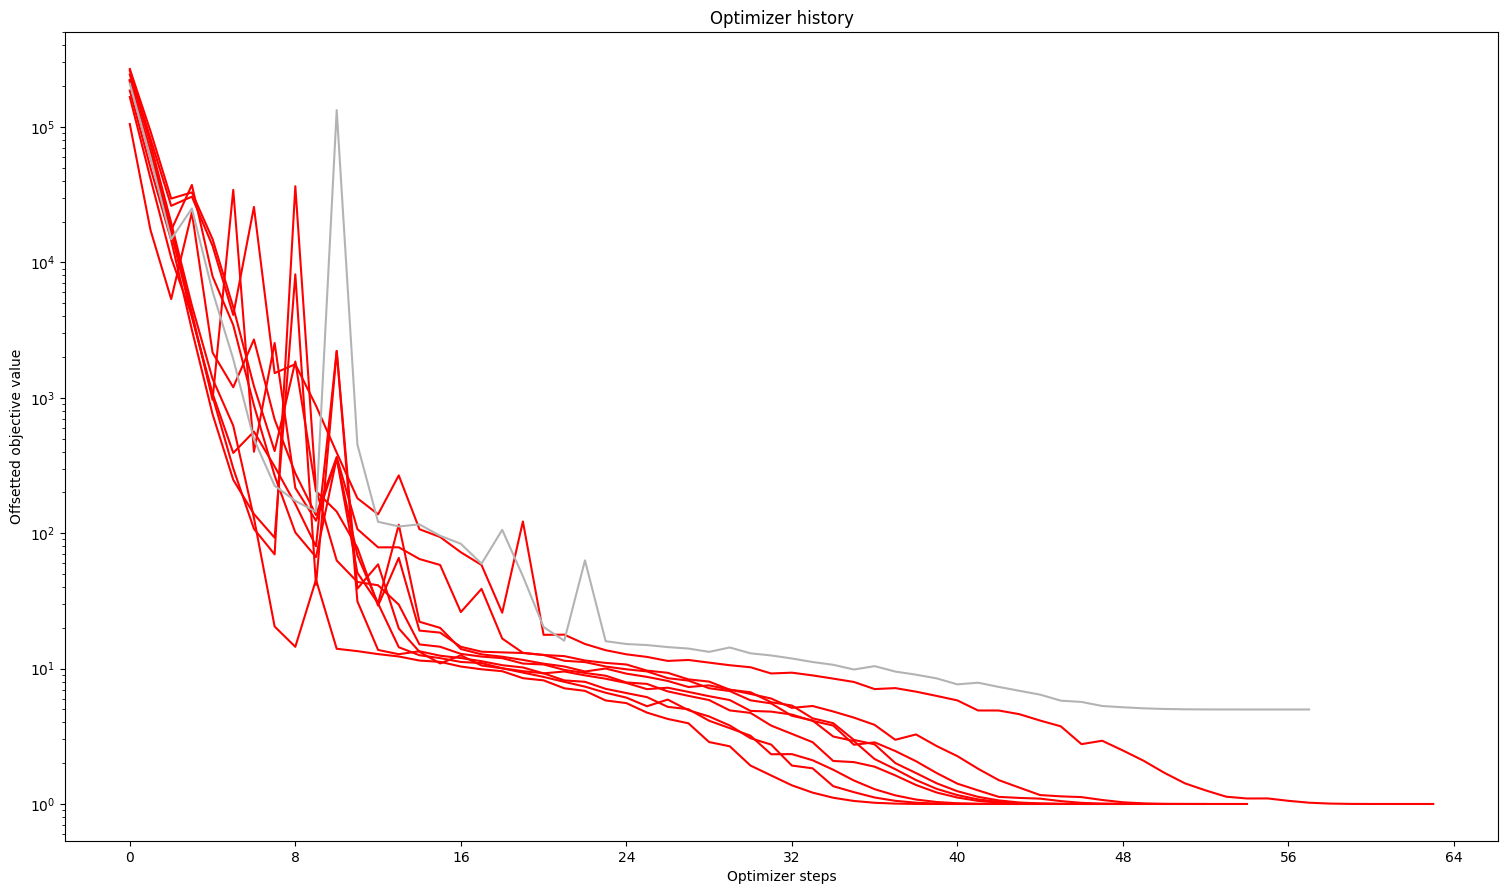

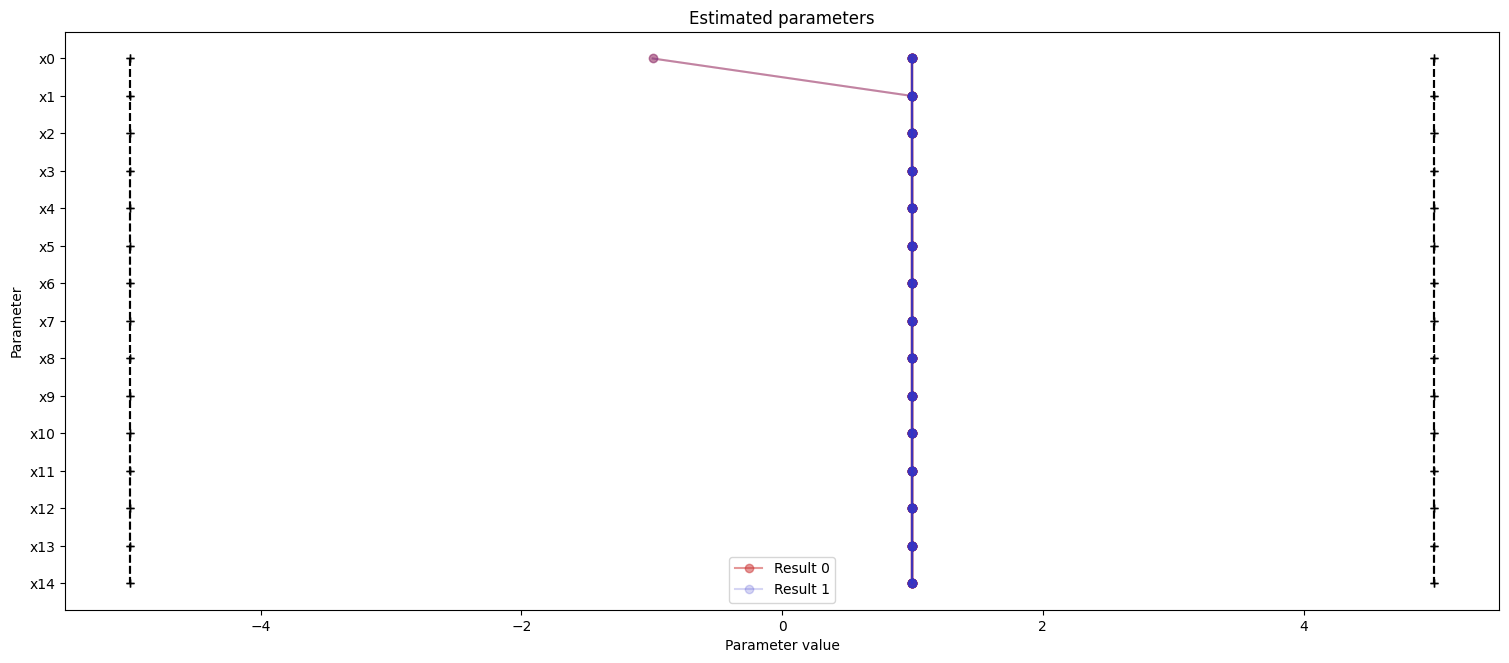

In [20]:
visualize.optimizer_history(result_from_history, trace_y="fval")
visualize.parameters([result_fides, result_from_history], colors=[[0.8, 0.2, 0.2, 0.5], [0.2, 0.2, 0.8, 0.2]]);

In [22]:
result_from_history.optimize_result[0].history.get_fval_trace() == result_fides.optimize_result[0].history.get_fval_trace()

True

Important to note here is, that we did **not use the result** saved in hdf5 to fill in the loaded result, but solely the history. This means, that if you use an `Hdf5History` during optimization and the optimization is interrupted, you can still load the optimization up to that point. From there you can for example restart the non finished (lets say e.g. the last 3) starts and finish optimizing them:

In [29]:
# we set x_guesses within the problem, to tell the optimization the startpoints of optimization
continued_problem = copy.deepcopy(problem)
continued_problem.set_x_guesses(result_from_history.optimize_result.x[-3:])

continued_result = optimize.minimize(
    problem=continued_problem,
    optimizer=fides_optimizer,
    n_starts=3,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 66.83it/s]


A final note on the `Hdf5History` together with the `MultiProcessEngine`.

If you use both together, the way the history works is the following:
- You specified a history file `fn_history` to store the result in
- A folder with the name `fn_history` will be created at the start of optimization
- Each optimization gets its own separate Hdf5 file within the folder named `fn_history_{id}`
- **After** optimization, the `fn_history` file will be created such that the folder is in the same directory and each result will be linked within this file, such that you can easily work with the `fn_history` file, that pools together all other histories

This also means, that if your optimization is interrupted, there is **no fn_history** file for pooling. In this case the `optimization_result_from_history` does not work nicely for all of them together. In this case you can load each result separately through the `optimization_result_from_history` and append the `optimize_result`'s together.